# Example of a composite model fit with LMFIT

This notebook shows one way to fit a pair of peaks in a spectrum (Co-60 gamma ray spectrum with NaI).

In [1]:
import numpy as np  # import the numpy library functions.
import matplotlib.pyplot as plt # plotting functions
import uncertainties as unc # Uncertainties package.  Good for simple error propagation
# directive below puts the plots in the notebook
%matplotlib inline

## Load the MCA reader package

The **mcareader** package is a small Python package that handles reading in data from `.mca` files.  It also allows inclusion of calibration data to rescale the spectra from channel numbers to some energy scale.

If you do not have mcareader installed already, execute the following cell:

In [ ]:
# You only need to do this once in a session

!pip install mcareader

If the import below fails, try the above.  Otherwise you should see a copy of a Co-60 spectrum

C:\Users\dbpengra.NETID\AppData\Local\Continuum\anaconda3\lib\site-packages\mcareader.py:68: UserWarning: Warning: no calibration data was found. Using channel number instead of energy
  warnings.warn("Warning: no calibration data was found. Using channel number instead of energy")


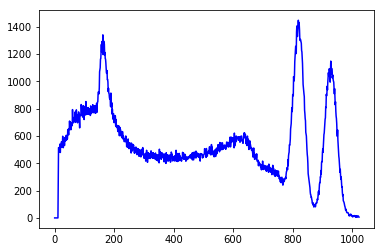

In [3]:
import mcareader as mca

Co60 = mca.Mca('Co-60_spectrum_9oct2020.mca')

### Ignore warnings about missing calibration data.  ###

(x, y) = Co60.get_points(trim_zeros=False)

plt.plot(x, y, '-b');

We only want the upper two peak positions and widths.  So we trim with a slice, and replot.

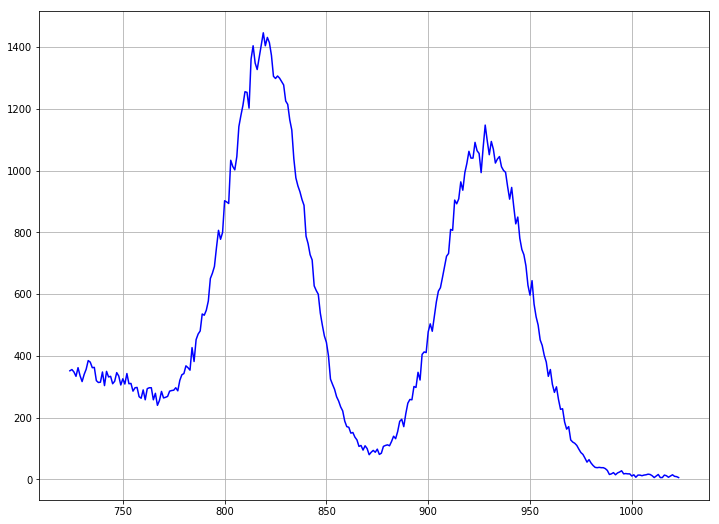

In [4]:
# Select the peaks at right with a slice

myfig = plt.figure(figsize=(12,9))
plt.grid()
plt.plot(x[-300:],y[-300:],'-b');

## Set up the composite model

Note how easily one can expand a fiting model by adding together existing models.  The prefixes help keep the different parameters distinct.

In [5]:
# Import a gaussian peak and second order polynomial for background

from lmfit.models import QuadraticModel, GaussianModel

# create an instance of the model
background = QuadraticModel()
peak1 = GaussianModel(prefix='p1_') # Note use of prefixes to keep parameters separate.
peak2 = GaussianModel(prefix='p2_')

# This makes the composite model
model = background + peak1 + peak2

# Thie creates parameters and names for the model
params = model.make_params()

print('parameter names: {}'.format(model.param_names))

parameter names: ['a', 'b', 'c', 'p1_amplitude', 'p1_center', 'p1_sigma', 'p2_amplitude', 'p2_center', 'p2_sigma']


## Set starting values for the parameters

This is an important restriction with composite models.  The `guess()` method does not work with composite models, so one must estimate them by hand.  Use the graph above.

For the Gaussian lineshape model, the parameters are `center` ($\mu$), `sigma` ($\sigma$) and `amplitude` ($A$) in the formula

$$ f(x;\mu,\sigma,A) = \frac{A}{\sigma\sqrt{2\pi}}e^{[-(x-\mu)^2/2\sigma^2]} $$

To estimate these, it is easiest to calculate $A$ and $\sigma$ from the peak height (above the baseline) ($H$) and the full width at half-maximum ($\Delta x_{1/2}$) by reading them from the graph.  The estimate does not need to be very precise.  Then calculate

$$ \sigma = \frac{\Delta x_{1/2}}{2\sqrt{2\ln2}} = \frac{\Delta x_{1/2}}{2.355} $$
and 
$$ A = H \sigma \sqrt{2\pi} = 2.5 H \sigma$$

In [6]:
# Read from graph
p1_FWHM = 40.0
p1_center = 820.
p1_height = 1000.0

p2_FWHM = 40
p2_center = 930.0
p2_height = 900.0

# Set the starting values
params['p1_sigma'].value = p1_FWHM/2.355
params['p1_center'].value = p1_center
params['p1_amplitude'].value = 2.5*p1_height*params['p1_sigma'].value

params['p2_sigma'].value = p2_FWHM/2.355
params['p2_center'].value = p2_center
params['p2_amplitude'].value = 2.5*p2_height*params['p2_sigma'].value

# Very crude estimates.  It looks like the background curves upward silghtly, 
# so I make `a` positive, there is a downward overall slope, so I make`b` negative
# and the baseline is around 1000 when I extrapolate back towards zero, so 
# I make `c` 1000.0
params['a'].value = +1.0
params['b'].value = -1.0
params['c'].value = 1000.0

params.pretty_print(columns=['value','vary'])


Name             Value     Vary
a                    1     True
b                   -1     True
c                 1000     True
p1_amplitude  4.246e+04     True
p1_center          820     True
p1_fwhm             40    False
p1_height        997.4    False
p1_sigma         16.99     True
p2_amplitude  3.822e+04     True
p2_center          930     True
p2_fwhm             40    False
p2_height        897.6    False
p2_sigma         16.99     True


## Run the fit

This is basically the same as for any other fit with LMfit.  Note the use of Poisson uncertainties to give error bars to the fitting procedure and associated plot.  These act as fitting "weights".

Weighting the fit is necessary to make sense of the chi-square and reduced chi-square fit quality calculations.

In [7]:
model_fit = model.fit(y[-300:], params, x=x[-300:], weights=1/np.sqrt(y[-300:]))

print(model_fit.fit_report(show_correl=False))


[[Model]]
    ((Model(parabolic) + Model(gaussian, prefix='p1_')) + Model(gaussian, prefix='p2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 300
    # variables        = 9
    chi-square         = 457.280522
    reduced chi-square = 1.57141073
    Akaike info crit   = 144.454369
    Bayesian info crit = 177.788411
[[Variables]]
    a:             0.00605497 +/- 2.2488e-04 (3.71%) (init = 1)
    b:            -11.7646648 +/- 0.39845375 (3.39%) (init = -1)
    c:             5715.47120 +/- 173.249253 (3.03%) (init = 1000)
    p1_amplitude:  57529.3194 +/- 474.391667 (0.82%) (init = 42462.85)
    p1_center:     819.956546 +/- 0.12336243 (0.02%) (init = 820)
    p1_sigma:      18.0697732 +/- 0.13166052 (0.73%) (init = 16.98514)
    p2_amplitude:  55918.1854 +/- 468.647648 (0.84%) (init = 38216.56)
    p2_center:     928.561310 +/- 0.12363385 (0.01%) (init = 930)
    p2_sigma:      20.5812164 +/- 0.14453792 (0.70%) (init = 16.98

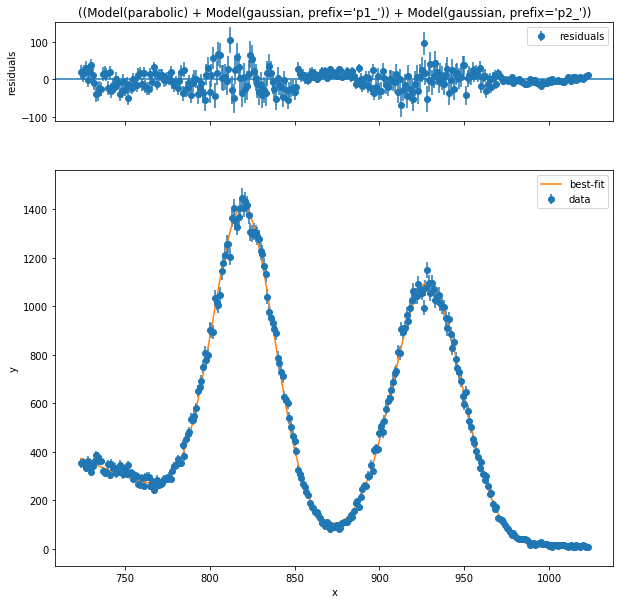

In [8]:
myfig=plt.figure(figsize=(10,10))
model_fit.plot(fig=myfig);